# Training Hello world model for Microcontrollers
> In this post, we'll cover the basic tutorial for training simple regression model with tensorflow lite for for Microcontrollers(TFLM). This post is the summary of youtube video "TinyML Book Screencast - Training the Hello World model", presented by peter warden.

- toc: true
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Tensorflow-Keras, Tensorflow-Lite]
- image:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (16, 10)


## Tensorflow Lite for Microcontrollers
[TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers) (TFLM for short) is designed to run machine learning models on microcontrollers and other devices with only few kilobytes of memory. For the purpose of deploying machine learning model on embedded devices, it is also called [TinyML](https://tinyml.org/home/). As you know already, Tensorflow is one of commonly-used deep learning frameworks, and from version 2.x they offer some machine learning features for embedded systems via tensorflow lite. Unlike high performance mobile processor(like cortex-A series), Microcontroller (Cortex-M series or ESP32) has low power consumptions and it can deploy in various ways of customer products, like refrigerator, wash-machine and so on.

Google introduced several supported boards for test,

- [Arduino Nano 33 BLE Sense](https://store.arduino.cc/usa/nano-33-ble-sense-with-headers) (using Arduino IDE)
- [SparkFun Edge](https://www.sparkfun.com/products/15170) (building directly from source)
- [STM32F746 Discovery kit](https://www.st.com/en/evaluation-tools/32f746gdiscovery.html) (using Mbed)
- [Adafruit EdgeBadge](https://www.adafruit.com/product/4400) (using Arduino IDE)
- [Adafruit TensorFlow Lite for Microcontrollers Kit](https://www.adafruit.com/product/4317) (using Arduino IDE)
- [Adafruit Circuit Playground Bluefruit](https://learn.adafruit.com/tensorflow-lite-for-circuit-playground-bluefruit-quickstart?view=all) (using Arduino IDE)
- [Espressif ESP32-DevKitC](https://www.espressif.com/en/products/hardware/esp32-devkitc/overview) (using ESP IDF)
- [Espressif ESP-EYE](https://www.espressif.com/en/products/hardware/esp-eye/overview) (using ESP IDF)

Here, we'll implement the simple regression model in **Sparkfun Edge**. Most of contents are covered in Pete Warden's screencast. More informations are included in his [book](https://www.oreilly.com/library/view/tinyml/9781492052036/).

> youtube: https://www.youtube.com/watch?v=8N6-WQsxwxA&t=205s

### Prerequisites for implementation
Before beginning, it requires some hardwares and basic knowledges,

- hardware
    - Sparkfun edge
    - CH340c USB-c to UART converter
    - Desktop PC for training model (or you can use google colab)
- Knowledge
    - Python
    - C/C++
    - Basic knowledge related on OS

### Hello world
Actually, "Hello world" may be the first program we faced, since it can show simple interaction between human and computer. TinyML also has simple example of "Hello world". Instead of Printing, we will build a model to generate the sine wave. So maybe our hypothesis will be like this,

$$ \tilde{H(x)} = \sin(x) $$

At first, we load the required packages,

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

# define random seed for reproducibility
np.random.seed(1) # numpy seed
tf.random.set_seed(1) # tensorflow global random seed

In [3]:
print('Numpy: {}'.format(np.__version__))
print('Tensorflow: {}'.format(tf.__version__))

Numpy: 1.23.5
Tensorflow: 2.13.0


To train the model, it requires a sort of data, namely training data. In our case, we will sample the random data from numpy and generate the actual output from known model(the sine function)

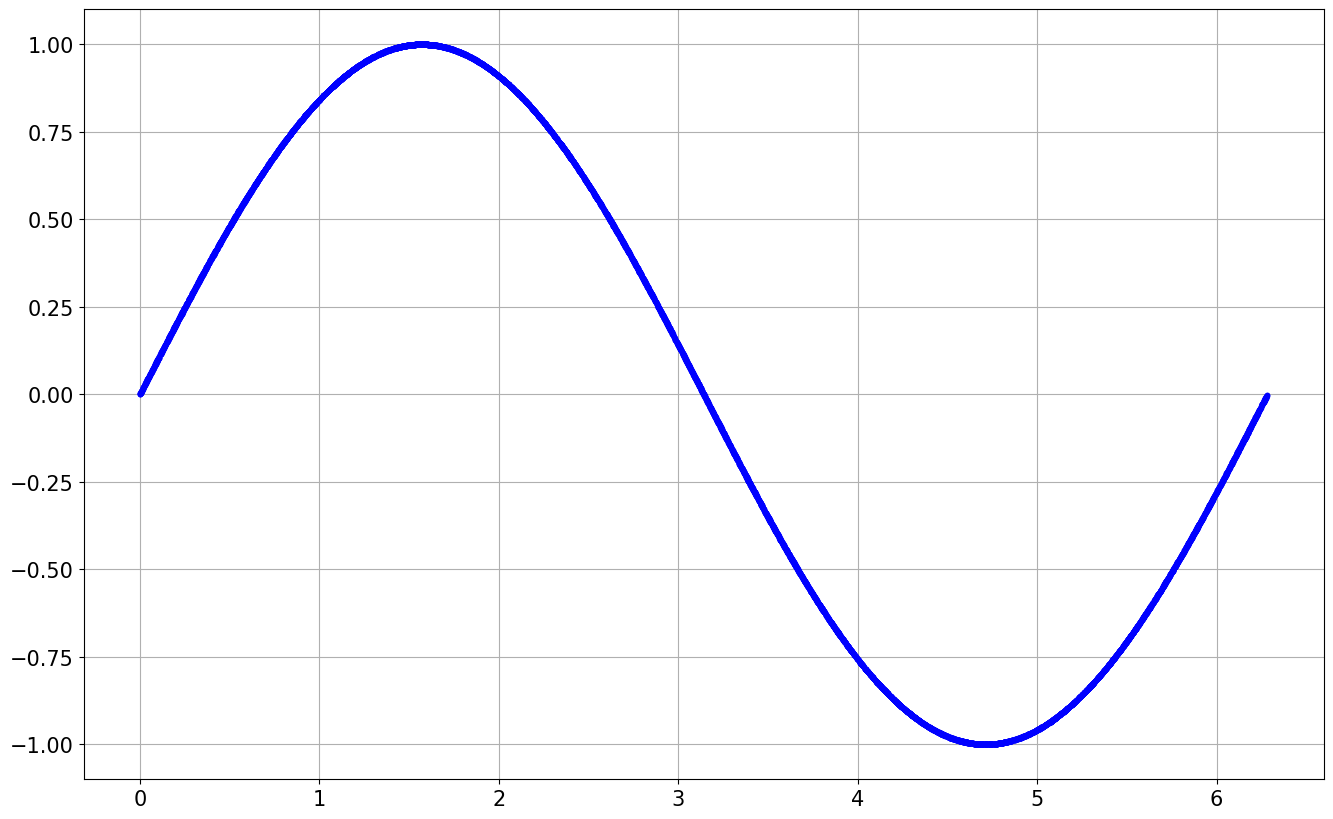

In [4]:
# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
X = np.random.uniform(
    low=0, high=2*math.pi, size=10000).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(X)

# Calculate the corresponding sine values
y = np.sin(X).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(X, y, 'b.')
plt.grid()
plt.show()

But this data doesn't reflect the real-world data, because there is no variation of distribution in dataset, also known as noise. We can add random data for each x, so it makes to seem more randomly distributed.

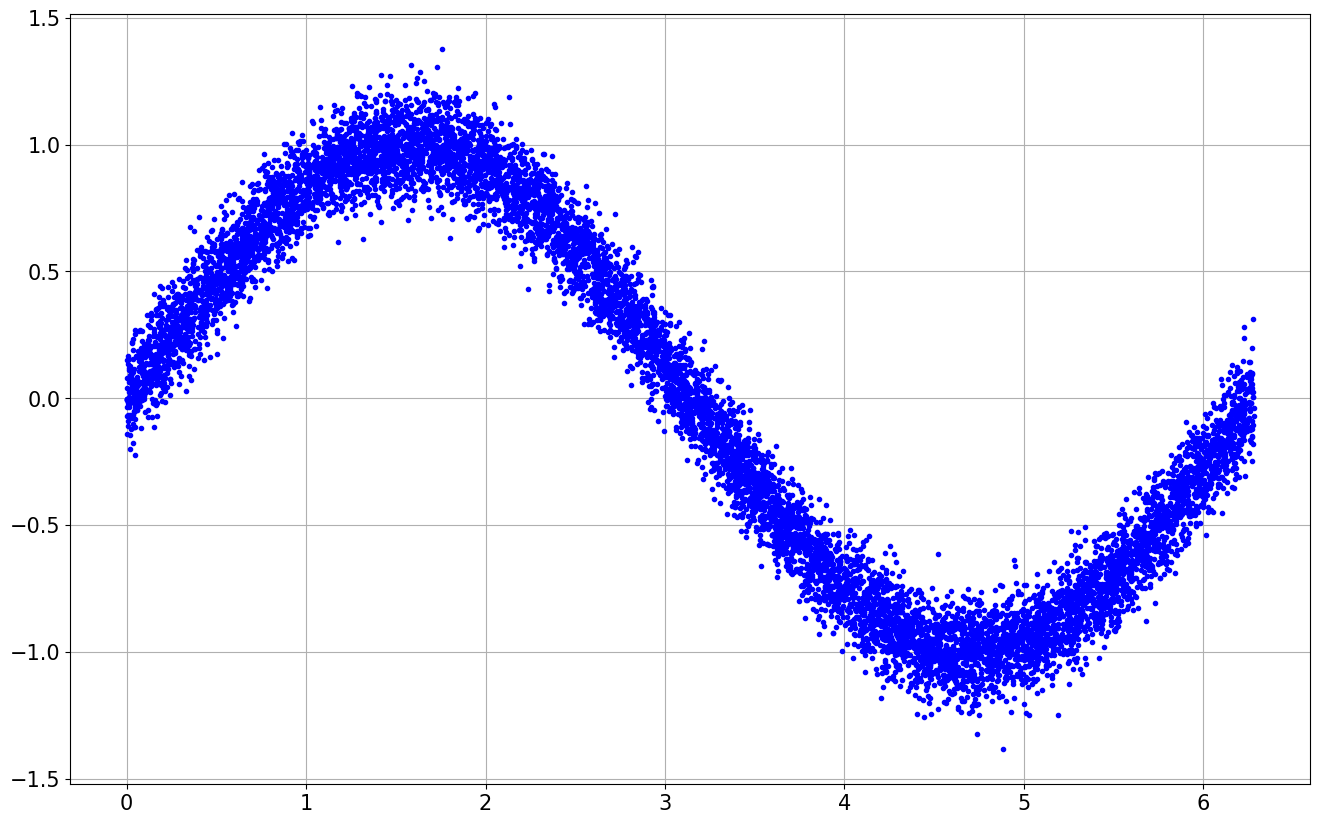

In [5]:
# Add a small random number to each y value
y += 0.1 * np.random.randn(*y.shape)

# Plot our data
plt.plot(X, y, 'b.')
plt.grid()
plt.show()

Through this, we expect that the model is approximated with sinusoid curve if it is well trained.

To use it for training, we are going to preprocess the data. We'll split it with following proportions,
    
- Train data: 60%
- Validation data: 20%
- Test data: 20%

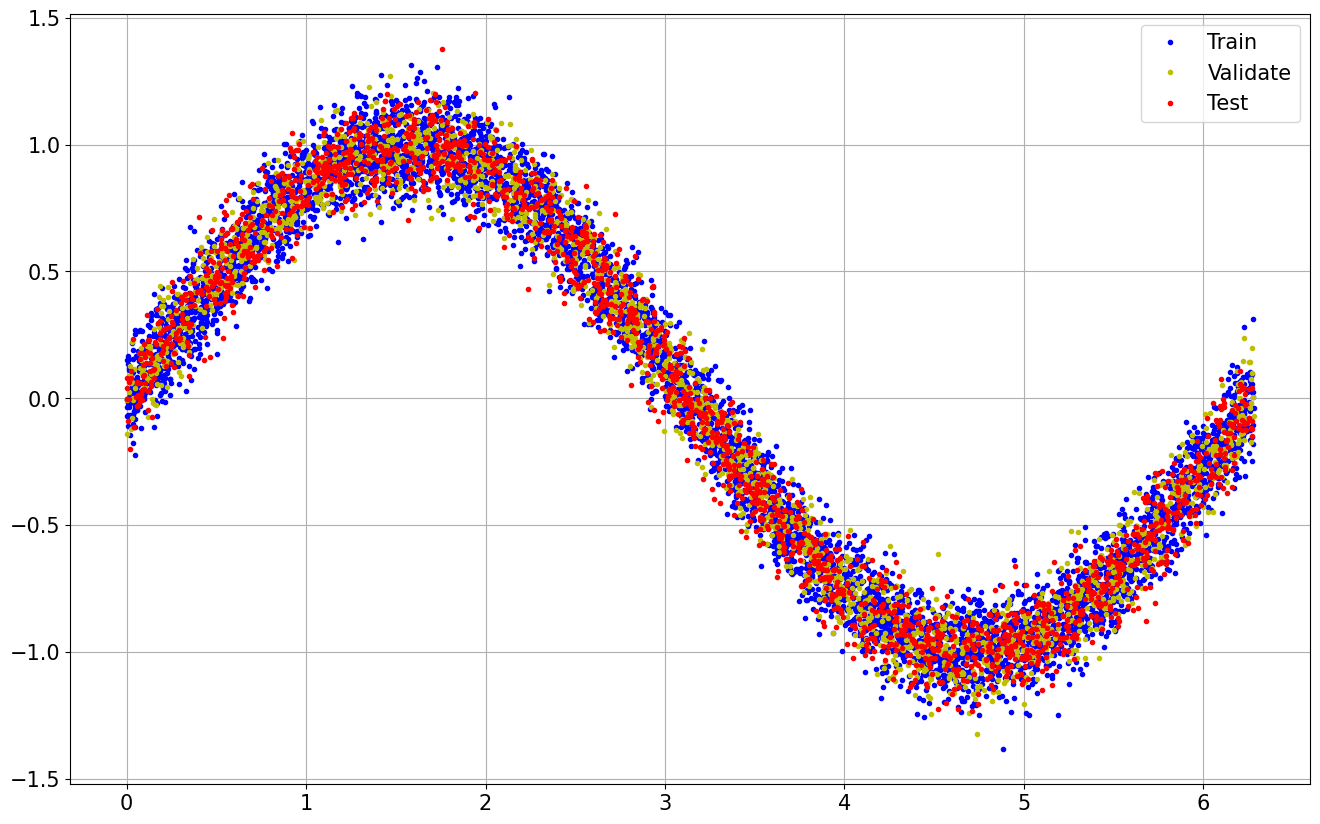

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Plot the data in each partition in different colors:
plt.plot(X_train, y_train, 'b.', label="Train")
plt.plot(X_val, y_val, 'y.', label="Validate")
plt.plot(X_test, y_test, 'r.', label="Test")
plt.legend()
plt.grid()
plt.show()

To train the model, we will use sequential model in tensorflow-keras, and add two Dense layer. Then we will add adam optimizer, and set mean squared error for loss.

In [7]:
model = tf.keras.Sequential(name='sine')
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sine"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])

Now, it's time to train the model.

In [9]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=15, validation_data=(X_val, y_val), verbose=False)

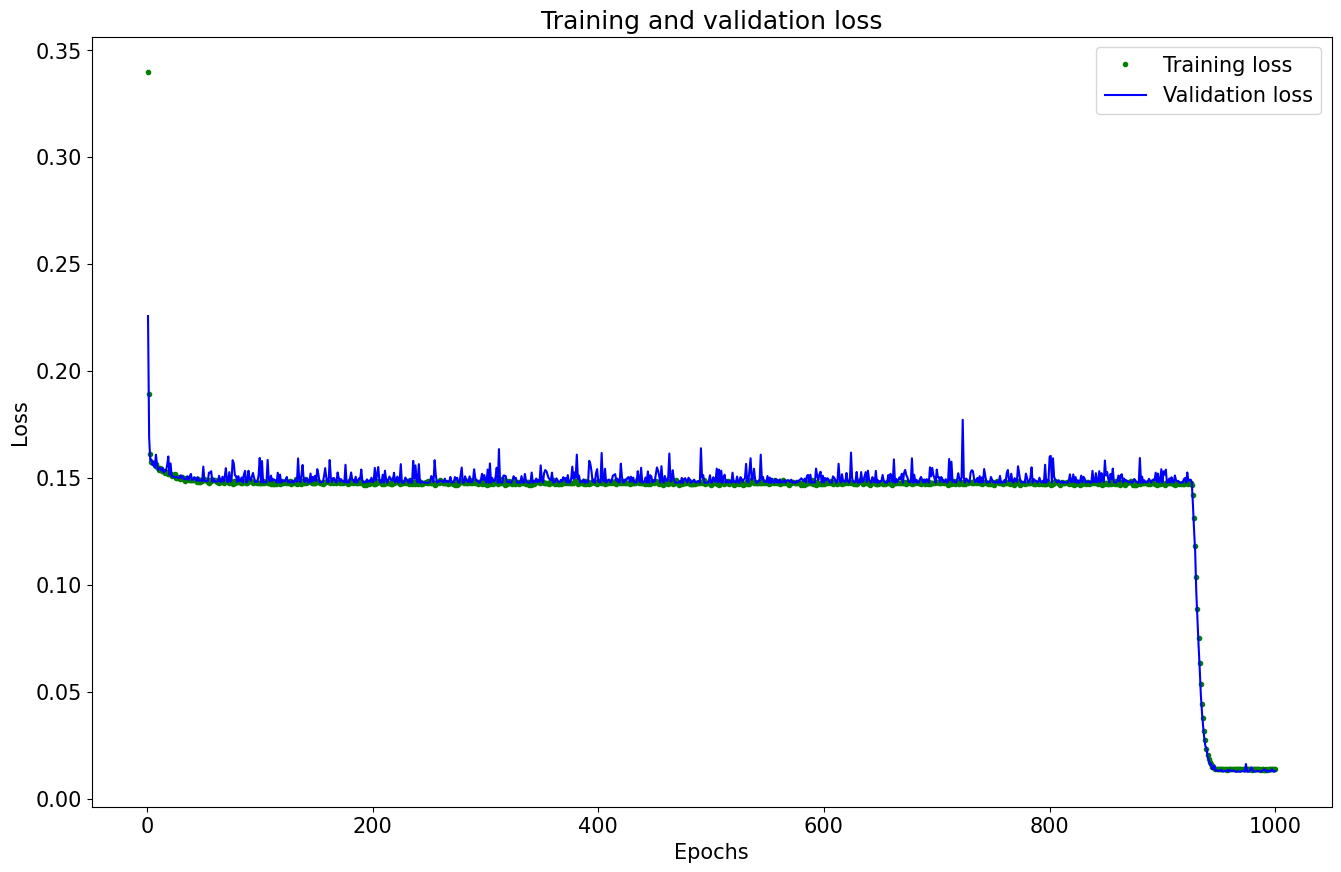

In [10]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

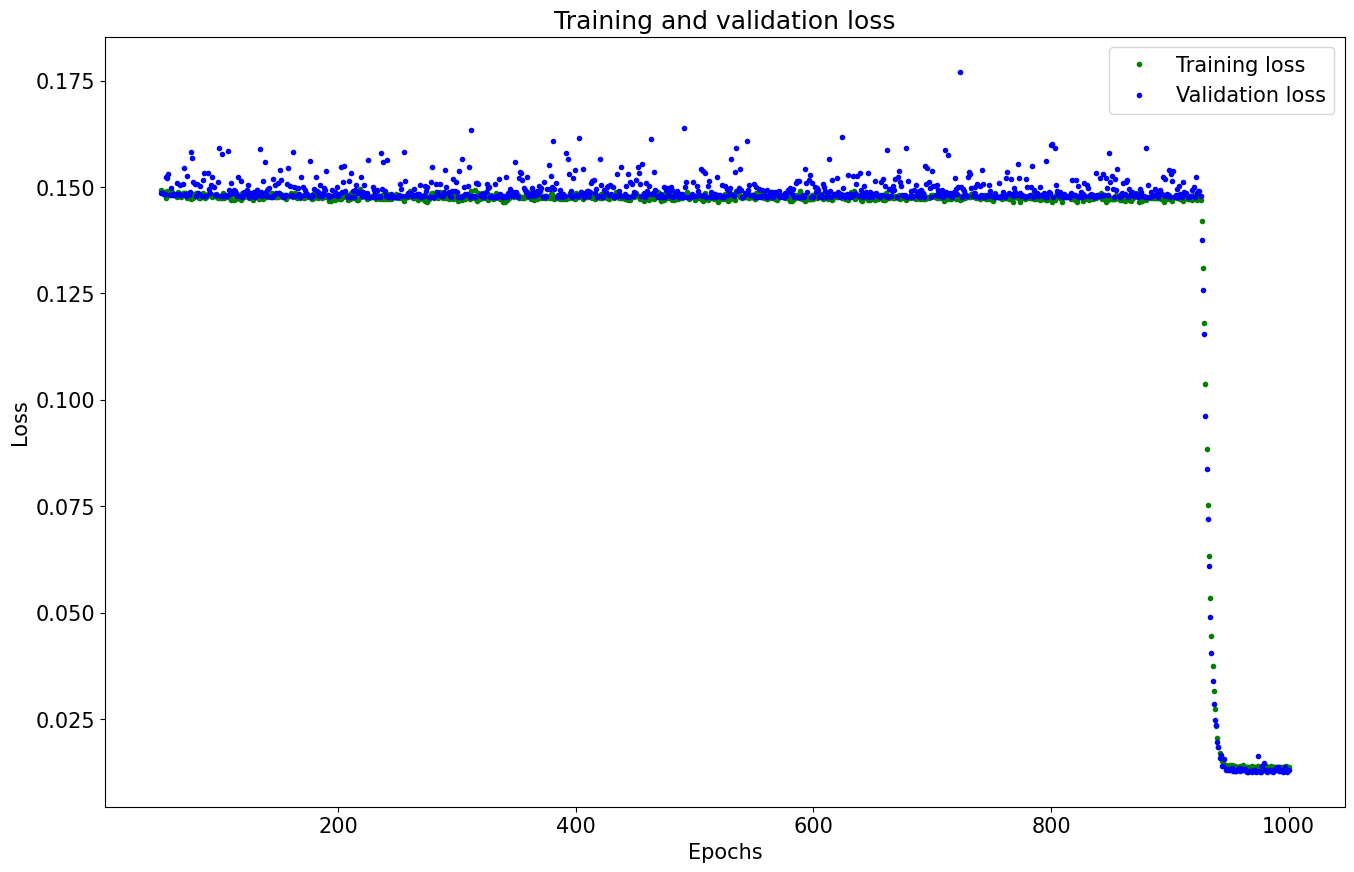

In [11]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

63/63 [==============================] - 0s 1ms/step


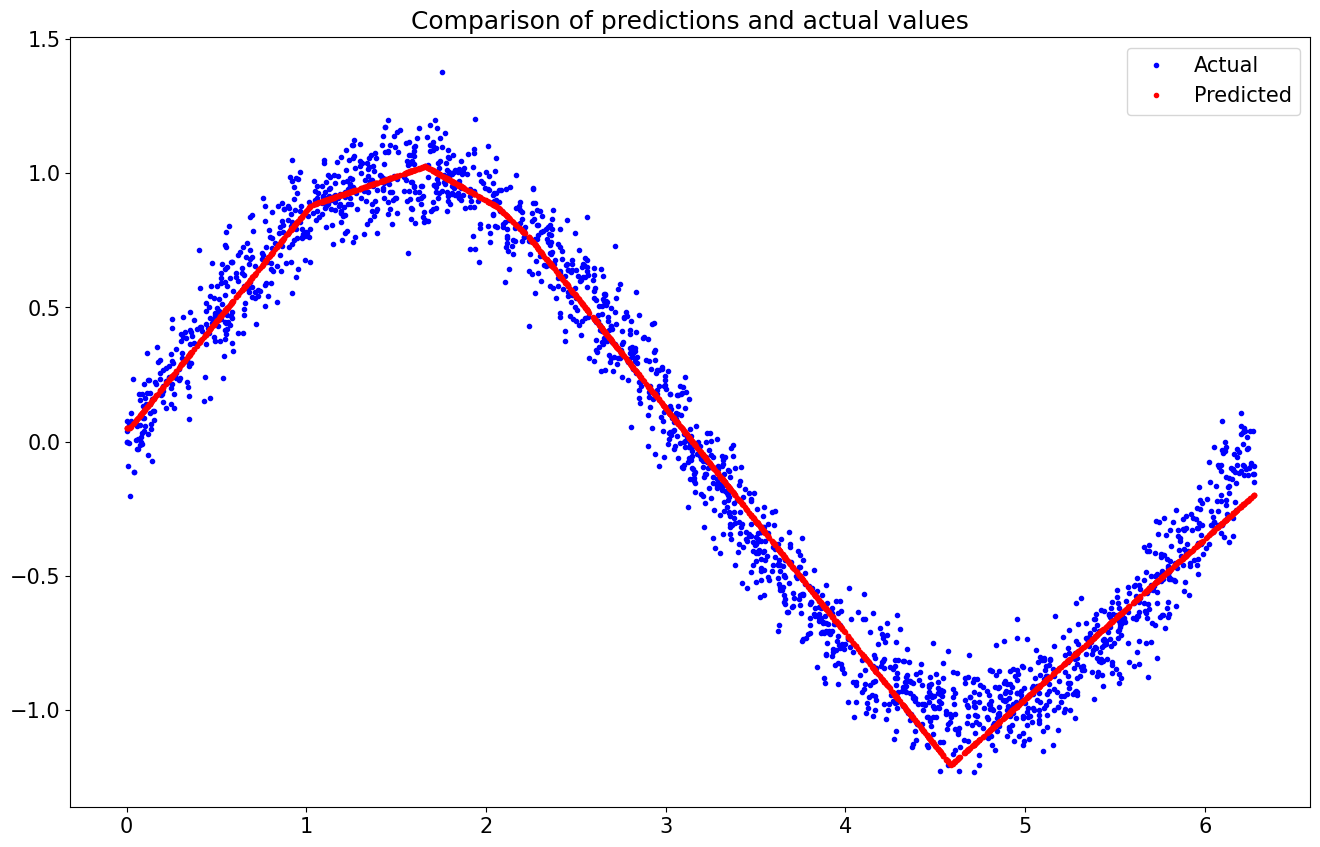

In [12]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(X_test, y_test)

# Make predictions based on our test dataset
predictions = model.predict(X_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(X_test, y_test, 'b.', label='Actual')
plt.plot(X_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

In [13]:
model_2 = tf.keras.Sequential(name='sine2')

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_2.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second layer may help the network learn more complex representations
model_2.add(tf.keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model_2.add(tf.keras.layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_2.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])

model_2.summary()

Model: "sine2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
history = model_2.fit(X_train, y_train, epochs=500, batch_size=64,
                    validation_data=(X_val, y_val), verbose=False)

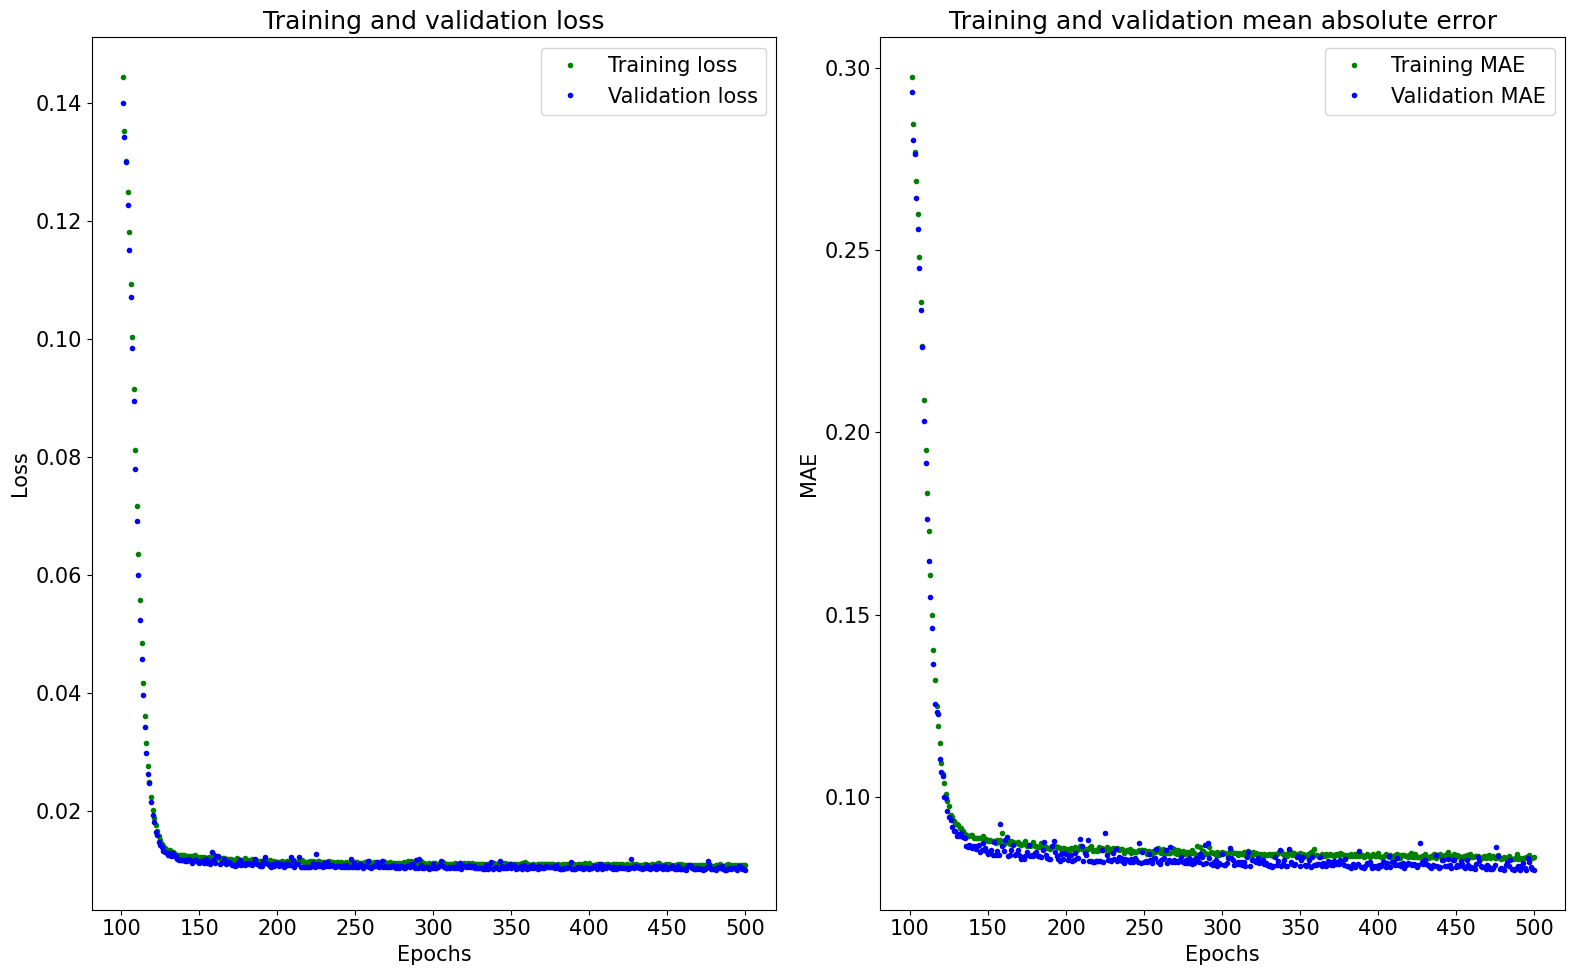

In [15]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure()
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

63/63 [==============================] - 0s 2ms/step


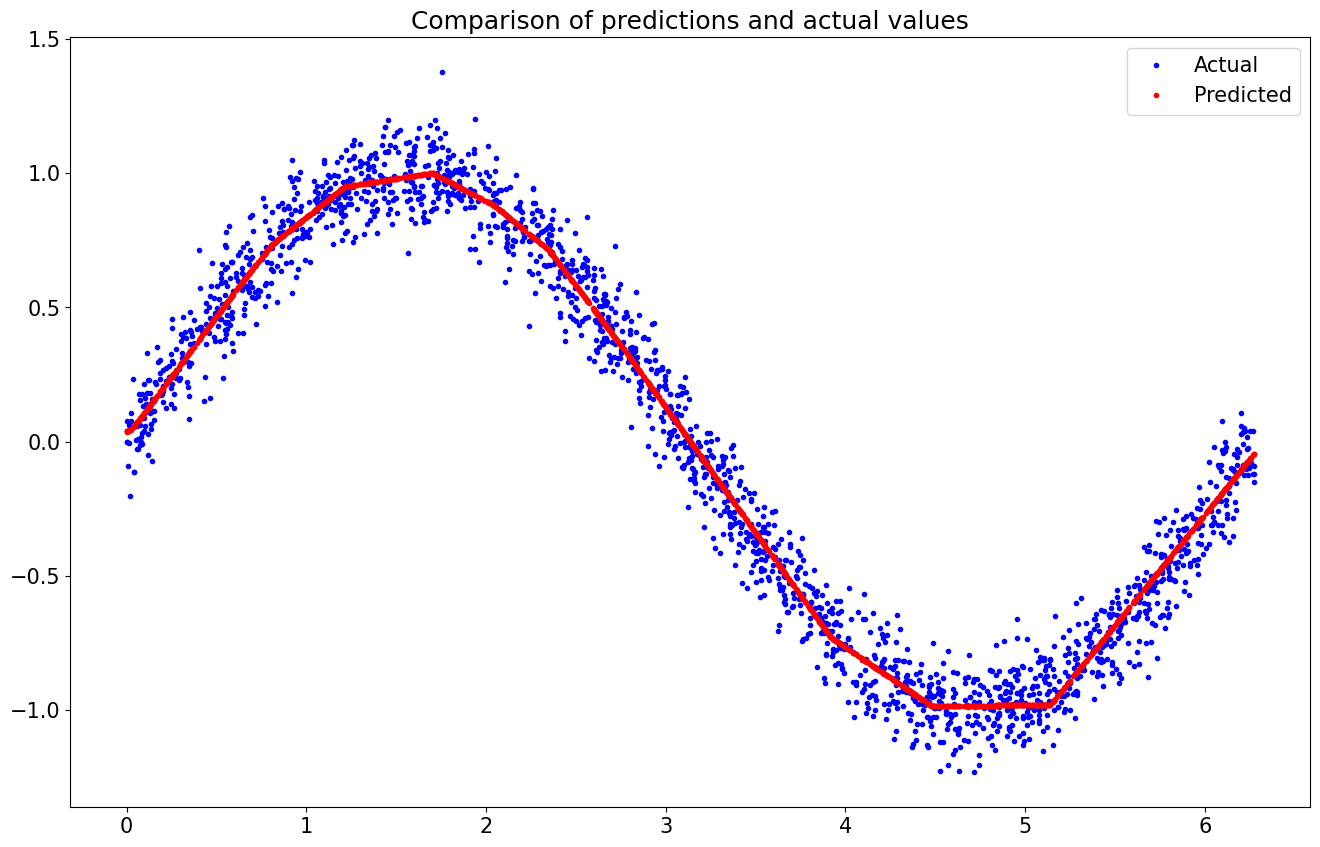

In [16]:
# Calculate and print the loss on our test dataset
loss = model_2.evaluate(X_test, y_test)

# Make predictions based on our test dataset
predictions = model_2.predict(X_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(X_test, y_test, 'b.', label='Actual')
plt.plot(X_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

In [17]:
import os
MODEL_DIR = './models/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

In [18]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
model_no_quant_tflite = converter.convert()

# # Save the model to disk
open(MODEL_DIR + 'model_no_quant.tflite', "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
    for i in range(500):
        yield([X_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization (except inputs/outputs which are always float)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_DIR + 'model.tflite', "wb").write(model_tflite)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


2976

In [19]:
model_no_quant_size = os.path.getsize(MODEL_DIR + 'model_no_quant.tflite')
print("Model is %d bytes" % model_no_quant_size)
model_size = os.path.getsize(MODEL_DIR + 'model.tflite')
print("Quantized model is %d bytes" % model_size)
difference = model_no_quant_size - model_size
print("Difference is %d bytes" % difference)

Model is 3128 bytes
Quantized model is 2976 bytes
Difference is 152 bytes


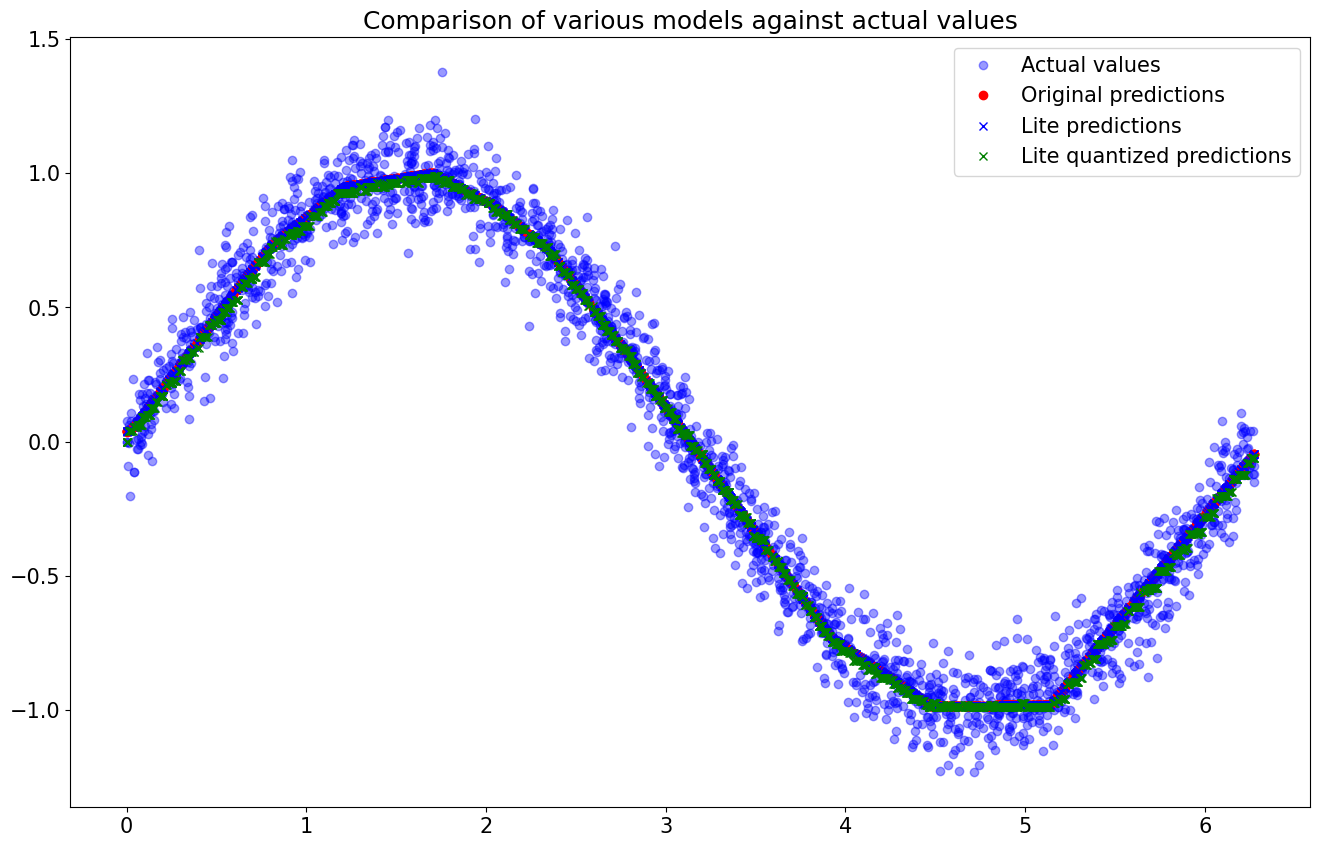

In [20]:
# Instantiate an interpreter for each model
model_no_quant = tf.lite.Interpreter(MODEL_DIR + 'model_no_quant.tflite')
model = tf.lite.Interpreter(MODEL_DIR + 'model.tflite')

# Allocate memory for each model
model_no_quant.allocate_tensors()
model.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
model_no_quant_input = model_no_quant.tensor(model_no_quant.get_input_details()[0]["index"])
model_no_quant_output = model_no_quant.tensor(model_no_quant.get_output_details()[0]["index"])
model_input = model.tensor(model.get_input_details()[0]["index"])
model_output = model.tensor(model.get_output_details()[0]["index"])

# Create arrays to store the results
model_no_quant_predictions = np.empty(X_test.size)
model_predictions = np.empty(X_test.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(X_test.size):
    model_no_quant_input().fill(X_test[i])
    model_no_quant.invoke()
    model_no_quant_predictions[i] = model_no_quant_output()[0]

    model_input().fill(X_test[i])
    model.invoke()
    model_predictions[i] = model_output()[0]

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(X_test, y_test, 'bo', label='Actual values', alpha=0.4)
plt.plot(X_test, predictions, 'ro', label='Original predictions')
plt.plot(X_test, model_no_quant_predictions, 'bx', label='Lite predictions')
plt.plot(X_test, model_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()

In [21]:
!xxd -i {MODEL_DIR + 'model.tflite'} > {MODEL_DIR + 'model.cc'}

In [22]:
!cat {MODEL_DIR + 'model.cc'}

unsigned char __models_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0xac, 0x03, 0x00, 0x00,
  0xbc, 0x03, 0x00, 0x00, 0x18, 0x0b, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0xfc, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x0b, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x34, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd6, 0xfc, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0d, 0x00, 0x00, 0x